<img width="100" src="https://carbonplan-assets.s3.amazonaws.com/monogram/dark-small.png" style="margin-left:0px;margin-top:20px"/>

# Forest Emissions Tracking - Validation

_CarbonPlan ClimateTrace Team_

This notebook compares our estimates of country-level forest emissions to prior
estimates from other groups. The notebook currently compares againsts:

- Global Forest Watch (Zarin et al. 2016)
- Global Carbon Project (Friedlingstein et al. 2020)


In [3]:
import geopandas
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt

from carbonplan_styles.mpl import set_theme

set_theme()

In [6]:
# Input data
# ----------

# country shapes from GADM36
countries = geopandas.read_file(
    "s3://carbonplan-climatetrace/inputs/shapes/countries.shp"
)

# CarbonPlan's emissions
emissions = {}
emissions['v0.1'] = pd.read_csv("s3://carbonplan-climatetrace/v0.1/country_rollups.csv")
for mechanism in ['fire', 'clearing']:
    emissions['v0.3-'+mechanism] = pd.read_csv("s3://carbonplan-climatetrace/v0.3/country_rollups_emissions_from_{}.csv".format(mechanism))
emissions['v0.3'] = emissions['v0.3-fire'].copy(deep=True)
emissions['v0.3']['tCO2eq'] = emissions['v0.3-fire']['tCO2eq']+emissions['v0.3-clearing']['tCO2eq']
# GFW emissions
gfw_emissions = pd.read_excel(
    "s3://carbonplan-climatetrace/validation/gfw_global_emissions.xlsx",
    sheet_name="Country co2 emissions",
).dropna(axis=0)
gfw_emissions = gfw_emissions[
    gfw_emissions["threshold"] == 10
]  # select threshold

# Global Carbon Project
gcp_emissions = (
    pd.read_excel(
        "s3://carbonplan-climatetrace/validation/Global_Carbon_Budget_2020v1.0.xlsx",
        sheet_name="Land-Use Change Emissions",
        skiprows=28,
    )
    .dropna(axis=1)
    .set_index("Year")
)
gcp_emissions *= 3.664  # C->CO2
gcp_emissions.index = [
    pd.to_datetime(f"{y}-01-01") for y in gcp_emissions.index
]
gcp_emissions = gcp_emissions[["GCB", "H&N", "BLUE", "OSCAR"]]

# Blue Sky Fire emissions
emisssions['Blue Sky'] = pd.read_csv(
    "s3://carbonplan-climatetrace/validation/forest-fires_bsa.csv")

In [7]:
versions = ['v0.1', 'v0.3']

In [8]:
# Merge emissions dataframes with countries GeoDataFrame
gfw_countries = countries.merge(
    gfw_emissions.rename(columns={"country": "name"}), on="name"
)
trace_countries = {}
for version in versions:
    trace_countries[version] = countries.merge(
        emissions[version].rename(columns={"iso3_country": "alpha3"}), on="alpha3"
    )

In [9]:
# reformat to "wide" format (time x country)
trace_wide = {}
for version in versions:
    trace_wide[version] = (
        emissions[version].drop(columns=["end_date"])
        .pivot(index="begin_date", columns="iso3_country")
        .droplevel(0, axis=1)
    )
    trace_wide[version].index = pd.to_datetime(trace_wide[version].index)

gfw_wide = (
    gfw_emissions.set_index("country")
    .filter(regex="whrc_aboveground_co2_emissions_Mg_.*")
    .T
)
gfw_wide.index = [pd.to_datetime(f"{l[-4:]}-01-01") for l in gfw_wide.index]

gfw_wide.head()

country,Angola,Anguilla,Antigua and Barbuda,Aruba,Bahamas,Bangladesh,Barbados,Belize,Benin,Bhutan,...,Timor-Leste,Togo,Trinidad and Tobago,Turks and Caicos Islands,Uganda,Venezuela,Vietnam,"Virgin Islands, U.S.",Zambia,Zimbabwe
2001-01-01,31136879.0,538.0,5376.0,0.0,62247.0,1926681.0,2948.0,2664263.0,2595676.0,140861.0,...,307218.0,1019587.0,641304.0,1059.0,10925954.0,37489138.0,18637306.0,33872.0,11120464.0,3341102.0
2002-01-01,16829411.0,22.0,3893.0,85.0,112943.0,1589109.0,2873.0,4076547.0,2780439.0,107165.0,...,704508.0,819767.0,253466.0,674.0,3159491.0,26071313.0,18995849.0,6316.0,15524726.0,3497928.0
2003-01-01,13910080.0,190.0,4064.0,156.0,41118.0,848477.0,794.0,2218989.0,4134499.0,227076.0,...,312124.0,948716.0,255138.0,1140.0,4203655.0,27666280.0,16483340.0,11361.0,15746559.0,3571212.0
2004-01-01,18427670.0,1327.0,6235.0,0.0,89321.0,1635774.0,2295.0,1320572.0,522435.0,497910.0,...,870732.0,1152064.0,276882.0,1325.0,5912218.0,27342980.0,28882631.0,10498.0,10901084.0,4330461.0
2005-01-01,23622906.0,571.0,16365.0,0.0,213287.0,1334780.0,2226.0,2578664.0,4509795.0,391291.0,...,565295.0,1276745.0,429870.0,2475.0,9948475.0,28190210.0,39344380.0,5310.0,22127861.0,5612324.0


## Part 1 - Compare time-averaged country emissions (tropics only)


In [10]:
# Create a new dataframe with average emissions
avg_emissions = countries.set_index("alpha3")
for version in versions:
    avg_emissions["trace-"+version] = trace_wide[version].mean().transpose()

avg_emissions = avg_emissions.set_index("name")
avg_emissions["gfw"] = gfw_wide.mean().transpose() / 1e9

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


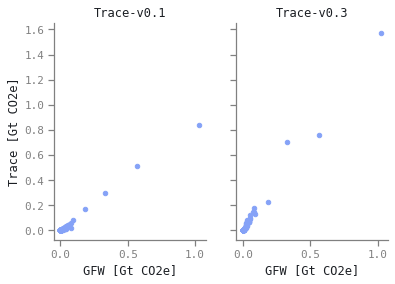

In [16]:
# Scatter Plot
fig, axarr = plt.subplots(ncols=2, sharey=True)
for i, version in enumerate(versions):
    avg_emissions.plot.scatter("gfw", "trace-"+version, ax=axarr[i])
    axarr[i].set_ylabel("Trace [Gt CO2e]")
    axarr[i].set_xlabel("GFW [Gt CO2e]")
    axarr[i].set_title("Trace-{}".format(version))

## Part 2 - Maps of Tropical Emissions


In [17]:
avg_emissions_nonan = avg_emissions.dropna()

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


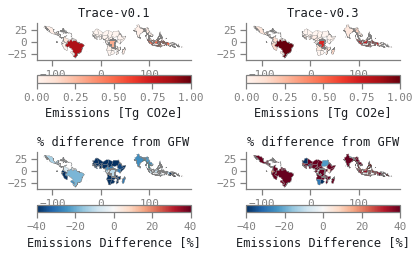

In [24]:
fig, axarr = plt.subplots(nrows=2, ncols=2)
for i, version in enumerate(versions):
    kwargs = dict(
        legend=True,
        legend_kwds={"orientation": "horizontal", "label": "Emissions [Tg CO2e]"},
        lw=0.25,
        cmap="Reds",
        vmin=0,
        vmax=1,
        ax=axarr[0,i]
    )
    avg_emissions_nonan.plot("trace-{}".format(version), **kwargs)
    axarr[0,i].set_title("Trace-{}".format(version))

for i, version in enumerate(versions):
    kwargs = dict(
    legend=True,
    legend_kwds={
        "orientation": "horizontal",
        "label": "Emissions Difference [%]",
    },
    lw=0.25,
    cmap="RdBu_r",
    vmin=-40,
    vmax=40,
    ax=axarr[1,i]
)
    avg_emissions_nonan["pdiff"] = (
        (avg_emissions_nonan["trace-{}".format(version)] - avg_emissions_nonan["gfw"])
        / avg_emissions_nonan["gfw"]
    ) * 100
    avg_emissions_nonan.plot("pdiff", **kwargs)
    axarr[1,i].set_title("% difference from GFW")
    
plt.tight_layout()

Text(0.5, 1.0, 'GFW Tropics')

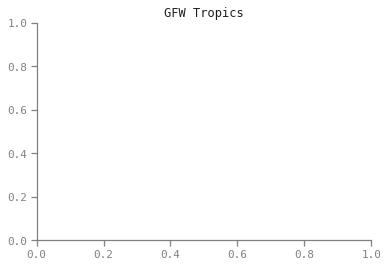

In [22]:
avg_emissions_nonan.plot("gfw", **kwargs)

plt.title("GFW Tropics")

## Part 3 - Compare trace_wideglobal emissions timeseries to Global Carbon Project


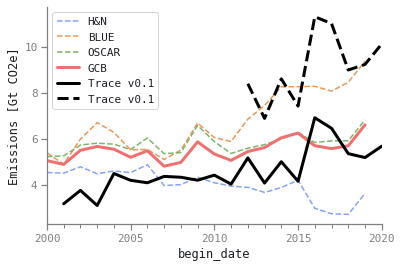

In [28]:
ax = gcp_emissions[["H&N", "BLUE", "OSCAR"]].loc["2000":].plot(ls="--")
gcp_emissions["GCB"].loc["2000":].plot(ax=ax, label="GCB", lw=3)
trace_wide['v0.1'].sum(axis=1).plot(ax=ax, label="Trace v0.1".format(version), c="k", lw=3)
trace_wide['v0.3'].sum(axis=1).plot(ax=ax, label="Trace v0.1".format(version), c="k", ls='--', lw=3)

plt.ylabel("Emissions [Gt CO2e]")
plt.legend()

## Part 4 - Compare fire emissions from CarbonPlan with those from Blue Sky

In [47]:
comparison = pd.merge(emissions['v0.3-fire'].rename({'tCO2eq': 'CarbonPlan'}, axis=1), 
                      emissions['Blue Sky'].rename({'tCO2': 'Blue Sky'}, axis=1),  how='left', left_on=['iso3_country','begin_date'], 
                      right_on = ['iso3_country','begin_date'])

In [48]:
comparison = comparison.drop(['end_date_x', 'end_date_y'], axis=1)
comparison['Blue Sky'] /= 1e9

In [49]:
for dataset in ['CarbonPlan', 'Blue Sky']:
    comparison = comparison.rename({dataset: dataset+' [GtCO2/year]'}, axis=1)

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
comparison.plot.scatter('CarbonPlan [GtCO2/year]', 'Blue Sky [GtCO2/year]', ax=ax)
ax.set_xlim(0,0.9)
ax.set_ylim(0,0.9)
plt.plot([0,1], [0,1], 'k-', lw=1)